In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import prettytable
import seaborn as sns
from tqdm import tqdm
import warnings
from sklearn import preprocessing
import os
from typing import Any, Callable, Dict
import polars as pl
import pybedtools
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

import copy


warnings.simplefilter(action="ignore")

In [202]:
df = pd.read_parquet('../data/04_feature/Homo_sapiens/n3/n3_concatenated_combined_functional_genomics_data.parquet')
df.columns[11:]

Index(['y_CTCF_ChIP_seq_peaks_distance', 'x_CTCF_ChIP_seq_peaks_distance',
       'x_DNase_seq_peaks_counts', 'y_DNase_seq_peaks_counts',
       'y_DNase_seq_peaks_distance', 'x_DNase_seq_peaks_distance',
       'x_DNase_seq_bigWig_mean', 'x_DNase_seq_bigWig_weighted_mean',
       'x_DNase_seq_bigWig_min', 'x_DNase_seq_bigWig_max',
       'y_DNase_seq_bigWig_mean', 'y_DNase_seq_bigWig_weighted_mean',
       'y_DNase_seq_bigWig_min', 'y_DNase_seq_bigWig_max',
       'x_CTCF_ChIP_seq_bigWig_mean', 'x_CTCF_ChIP_seq_bigWig_weighted_mean',
       'x_CTCF_ChIP_seq_bigWig_min', 'x_CTCF_ChIP_seq_bigWig_max',
       'y_CTCF_ChIP_seq_bigWig_mean', 'y_CTCF_ChIP_seq_bigWig_weighted_mean',
       'y_CTCF_ChIP_seq_bigWig_min', 'y_CTCF_ChIP_seq_bigWig_max',
       'x_MA0139.1_f', 'x_MA0139.1_r', 'x_MA1929.1_f', 'x_MA1929.1_r',
       'x_MA1930.1_f', 'x_MA1930.1_r', 'y_MA0139.1_r', 'y_MA0139.1_f',
       'y_MA1929.1_r', 'y_MA1929.1_f', 'y_MA1930.1_r', 'y_MA1930.1_f',
       'distance'],
      dtype='o

In [213]:
cechy = list(df.columns[11:]) + ['x_CTCF_ChIP_seq_peaks_counts',
 'y_CTCF_ChIP_seq_peaks_counts']

In [196]:
df_pos = df[df['label']==1]
df_pos = df_pos.iloc[:, 9:]
corr_df = df_pos.corr()

In [232]:
new_corr = np.abs(corr_df.loc[:,ccc])
for c in new_corr.columns:
    new_corr.loc[c,c]=0
new_corr['y_MA1540.2_f']

x_CTCF_ChIP_seq_peaks_counts      0.051329
y_CTCF_ChIP_seq_peaks_counts      0.054698
y_CTCF_ChIP_seq_peaks_distance    0.012841
x_CTCF_ChIP_seq_peaks_distance    0.011083
x_DNase_seq_peaks_counts          0.130038
                                    ...   
y_MA0597.2_f                      0.142576
y_MA0597.2_r                      0.106332
y_MA1540.2_r                      0.125334
y_MA1540.2_f                      0.000000
distance                          0.006556
Name: y_MA1540.2_f, Length: 3369, dtype: float64

In [4]:
df.columns[]

3367

In [6]:
len(df.columns[11:])

35

In [8]:
len(df.columns[11:])

3367

In [197]:
df_pos = df[df['label']==1]
df_pos.columns

Index(['chr', 'x', 'x_start', 'x_end', 'y', 'y_start', 'y_end', 'cell_type',
       'label', 'x_CTCF_ChIP_seq_peaks_counts',
       ...
       'y_MA1630.2_r', 'y_MA1633.2_r', 'y_MA1633.2_f', 'y_MA1647.2_r',
       'y_MA1647.2_f', 'y_MA0597.2_f', 'y_MA0597.2_r', 'y_MA1540.2_r',
       'y_MA1540.2_f', 'distance'],
      dtype='object', length=3378)

In [3]:
# Positive counts for each cell type
for c in list(set(df['cell_type'])):
    print(c+': '+str(len(df[(df['cell_type']==c)&(df['label']==1)])))

IMR90: 8040
NHEK: 4929
HUVEC: 3865
GM12878: 9448
K562: 6057
HMEC: 5152
HeLa: 3094


In [20]:
motifs = ['x_MA1930.1_f',	
         'x_MA1930.1_r',
         'y_MA1930.1_f',	
         'y_MA1930.1_r',	
         'y_MA0139.1_r',
         'y_MA0139.1_f',
         'x_MA0139.1_r',
         'x_MA0139.1_f',
         'y_MA1929.1_r',
         'y_MA1929.1_f',
         'x_MA1929.1_r',
         'x_MA1929.1_f']
df['motifs_count'] = 0
df['x_motifs_count'] = 0
df['y_motifs_count'] = 0
for m in motifs:
    df['motifs_count'] += df[m]
    if m.startswith('x'):
        df['x_motifs_count'] += df[m]
    else:
        df['y_motifs_count'] += df[m]

for c in list(set(df['cell_type'])):
    print(c+': '+str(len(df[(df['label']==1)&(df['motifs_count']==0)&(df['cell_type']==c)])))

print('all: '+str(len(df[(df['label']==1)&(df['motifs_count']==0)])))

IMR90: 5092
NHEK: 4793
HUVEC: 3169
GM12878: 7924
K562: 4030
HMEC: 4120
HeLa: 2707
all: 31835


In [23]:
df['CTCF_ChIP_seq_signal_counts'] = df['x_CTCF_ChIP_seq_peaks_counts'] + df['y_CTCF_ChIP_seq_peaks_counts']

for c in list(set(df['cell_type'])):
    print(c+': '+str(len(df[(df['label']==1)&(df['CTCF_ChIP_seq_signal_counts']==0)&(df['cell_type']==c)])))

print('all: '+str(len(df[(df['label']==1)&(df['CTCF_ChIP_seq_signal_counts']==0)])))

IMR90: 1668
NHEK: 2629
HUVEC: 1592
GM12878: 1756
K562: 1618
HMEC: 928
HeLa: 1242
all: 11433


In [17]:
len(df[(df['label']==1)])

40585

In [29]:
fly = pd.read_csv('../data/01_raw/D_melanogaster/HiC_loops_annotations/long_and_short_range_loops_D_mel.tsv', sep='\t')
fly['x_size'] = fly['x2']-fly['x1']
fly['y_size'] = fly['y2']-fly['y1']
np.max(fly['y_size'])
fly.sort_values('x_size', ascending=False)

,chr1,x1,x2,chr2,y1,y2,color,loop_id,in_16-18h_WE,in_CNS_L3,in_WB_adult,x_size,y_size
179,3R,1435000,1500000,3R,4140000,4200000,"85,107,47",L180,1,1,1,65000,60000
180,3R,2385000,2445000,3R,4135000,4200000,"85,107,47",L181,1,1,1,60000,65000
178,3R,1437500,1487500,3R,2392500,2432500,"85,107,47",L179,1,1,1,50000,40000
240,X,7750000,7779000,X,7817500,7835000,"0,0,255",L241,0,1,0,29000,17500
150,3L,5265000,5290000,3L,5320000,5335000,"0,0,255",L151,0,1,0,25000,15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,3L,4800832,4800919,3L,7013903,7013999,"85,107,47",L33,1,1,0,87,96
31,3L,1997924,1998004,3L,2228637,2229443,"0,0,255",L32,0,1,0,80,806
8,2L,2109979,2110059,2L,10964198,10964712,"85,107,47",L9,1,1,0,80,514
30,3L,866555,866635,3L,2228637,2229443,"85,107,47",L31,1,1,0,80,806


In [36]:
h = pd.read_csv('../data/01_raw/Homo_sapiens/HiC_loops_annotations/GSE63525_HeLa_HiCCUPS_looplist.txt', sep='\t')
h['x_size'] = h['x2']-h['x1']
h['y_size'] = h['y2']-h['y1']
set(h['x_size'])
set(h['y_size'])

{5000, 10000, 25000}

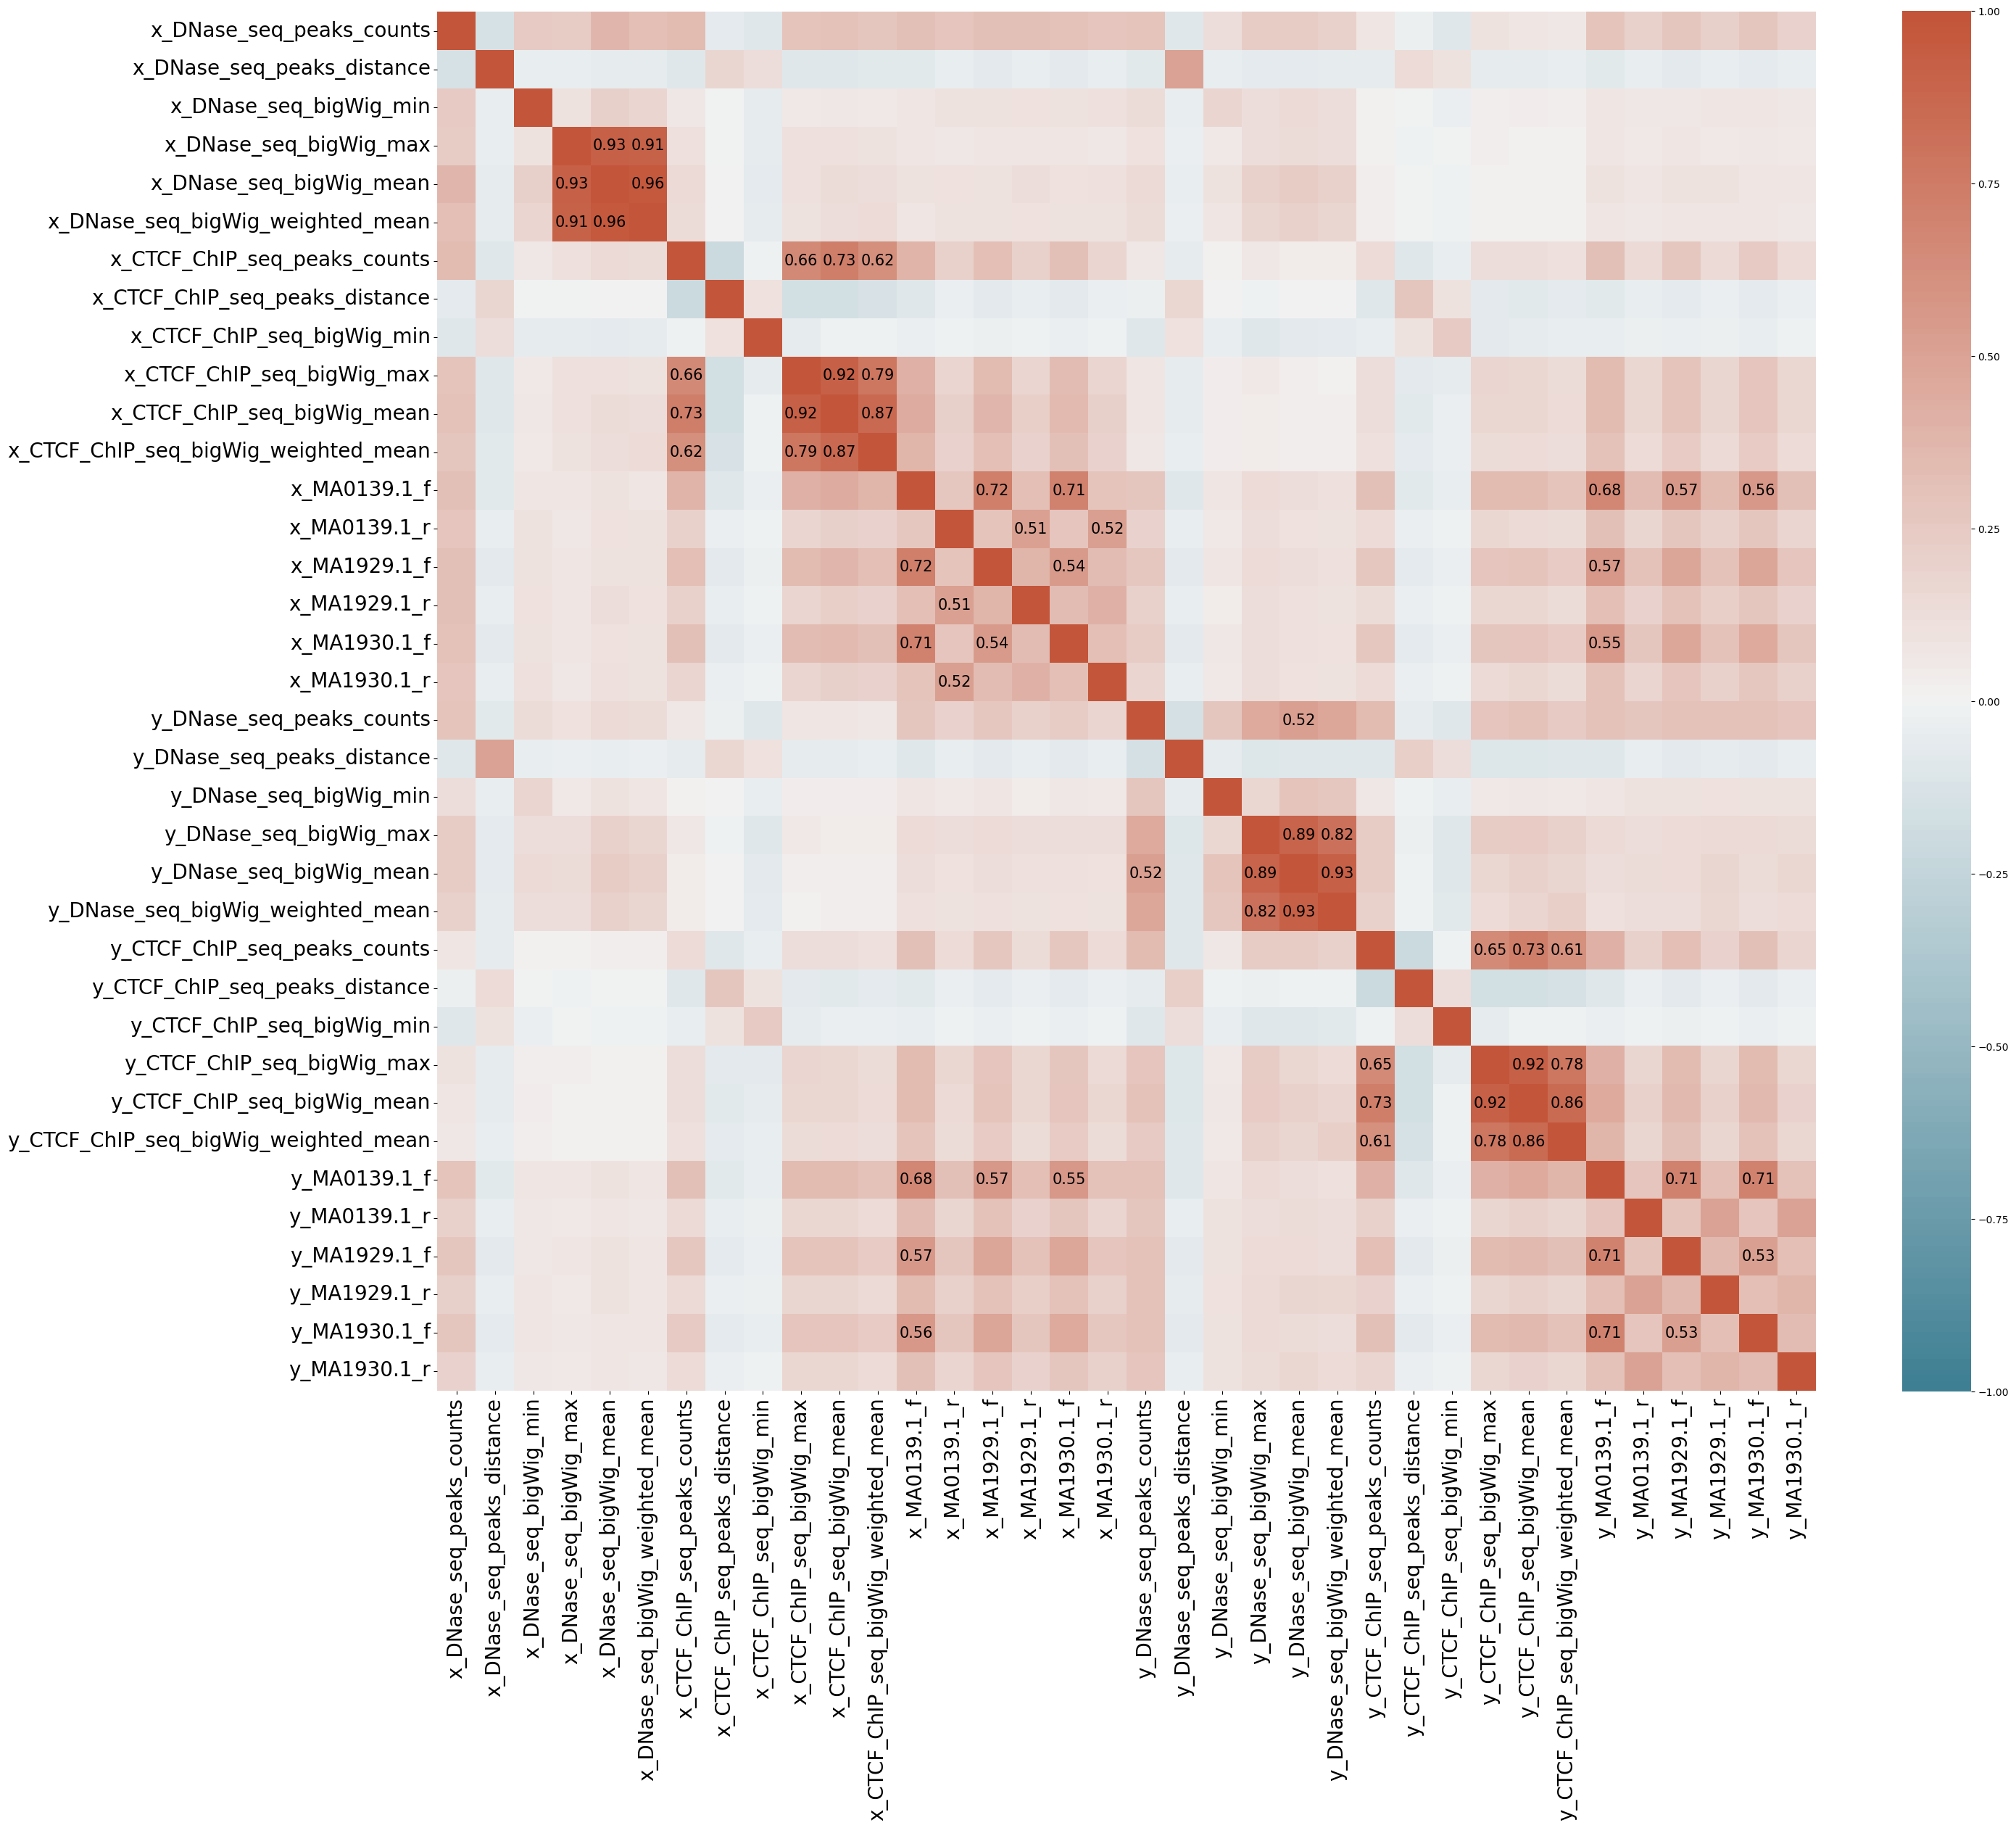

In [204]:
fig, axs = plt.subplots(figsize=(30, 25))

df_pos = df[df['label']==1]

corr = df_pos[['x_DNase_seq_peaks_counts', 'x_DNase_seq_peaks_distance', 'x_DNase_seq_bigWig_min', 'x_DNase_seq_bigWig_max','x_DNase_seq_bigWig_mean','x_DNase_seq_bigWig_weighted_mean',
               'x_CTCF_ChIP_seq_peaks_counts', 'x_CTCF_ChIP_seq_peaks_distance','x_CTCF_ChIP_seq_bigWig_min','x_CTCF_ChIP_seq_bigWig_max','x_CTCF_ChIP_seq_bigWig_mean','x_CTCF_ChIP_seq_bigWig_weighted_mean',
               'x_MA0139.1_f', 'x_MA0139.1_r', 'x_MA1929.1_f', 'x_MA1929.1_r','x_MA1930.1_f', 'x_MA1930.1_r', 
               'y_DNase_seq_peaks_counts', 'y_DNase_seq_peaks_distance', 'y_DNase_seq_bigWig_min', 'y_DNase_seq_bigWig_max','y_DNase_seq_bigWig_mean','y_DNase_seq_bigWig_weighted_mean',
               'y_CTCF_ChIP_seq_peaks_counts','y_CTCF_ChIP_seq_peaks_distance','y_CTCF_ChIP_seq_bigWig_min','y_CTCF_ChIP_seq_bigWig_max','y_CTCF_ChIP_seq_bigWig_mean','y_CTCF_ChIP_seq_bigWig_weighted_mean',
                'y_MA0139.1_f', 'y_MA0139.1_r','y_MA1929.1_f', 'y_MA1929.1_r','y_MA1930.1_f', 'y_MA1930.1_r'
                ]].corr()

def func(x, thres):
    if (round(x,2) > thres or round(x,2) < -thres) and x != 1:
        return str(round(x,2))
    else:
        return ""

corr_annot = corr.applymap(lambda x: func(x, 0.5))

sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    annot=corr_annot,
    fmt = '',
    annot_kws={"fontsize":15, "color":'black'},
)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

fig.tight_layout()
fig.savefig('positives_feature_correlation_heatmap.png', bbox_inches='tight')

In [157]:
def create_distplot(df, statistic: str, experiment: str, xlim: tuple = None):
    fig, axs = plt.subplots(figsize=(10, 10))

    # Iterate through the five airlines
    for cell_type, df_cell in df.groupby('cell_type'):
        sns.distplot(df_cell.loc[df_cell['label']==1, f'x_{experiment}_{statistic}'], hist = False, kde = True,
                    kde_kws = {'linewidth': 2},
                    label = cell_type)
        plt.legend(title = 'Typ komórki', fontsize = 12, title_fontsize = 12)
        if xlim:
            plt.xlim(xlim)
        plt.title(f'Rozkłady cechy "x_{experiment}_{statistic}"\ndla pozytywnych przykładów w rożnych komórkach', size=15)
        plt.xlabel(f'Wartości cechy "x_{experiment}_{statistic}"', size=15)
        plt.ylabel('Gęstość', size=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
    # tight layout
    plt.show()
    if input('Save?')=='True':
        fig.savefig(f'x_{experiment}_{statistic}_distplot_positives.png', bbox_inches='tight', dpi=300)

In [99]:
def create_neg_distplot(df, statistic: str, experiment: str, xlim: tuple = None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Iterate through the five airlines
    for cell_type, df_cell in df:
        sns.distplot(df_cell.loc[df_cell['label']==1, f'x_{experiment}_{statistic}'], hist = False, kde = True,
                    kde_kws = {'linewidth': 3},
                    label = cell_type,
                    ax=axs[0, 0])
        axs[0,0].legend(title = 'Cell type')
        if xlim:
            axs[0,0].set_xlim(xlim)
        axs[0,0].set_title(f'x {experiment} {statistic}\nfor positive samples')

        sns.distplot(df_cell.loc[df_cell['label']==0, f'x_{experiment}_{statistic}'], hist = False, kde = True,
                        kde_kws = {'linewidth': 3},
                        label = cell_type,
                        ax=axs[0, 1])
        axs[0,1].legend(title = 'Cell type')
        if xlim:
            axs[0,1].set_xlim(xlim)
        axs[0,1].set_title(f'x {experiment} {statistic}\nfor negative samples')

        sns.distplot(df_cell.loc[df_cell['label']==1, f'y_{experiment}_{statistic}'], hist = False, kde = True,
                        kde_kws = {'linewidth': 3},
                        label = cell_type,
                        ax=axs[1, 0])
        axs[1,0].legend(title = 'Cell type')
        if xlim:
            axs[1,0].set_xlim(xlim)
        axs[1,0].set_title(f'y {experiment} {statistic}\nfor positive samples')

        sns.distplot(df_cell.loc[df_cell['label']==0, f'y_{experiment}_{statistic}'], hist = False, kde = True,
                        kde_kws = {'linewidth': 3},
                        label = cell_type,
                        ax=axs[1, 1])
        axs[1,1].legend(title = 'Cell type')
        if xlim:
            axs[1,1].set_xlim(xlim)
        axs[1,1].set_title(f'y {experiment} {statistic}\nfor negative samples')
    # tight layout
    plt.tight_layout()

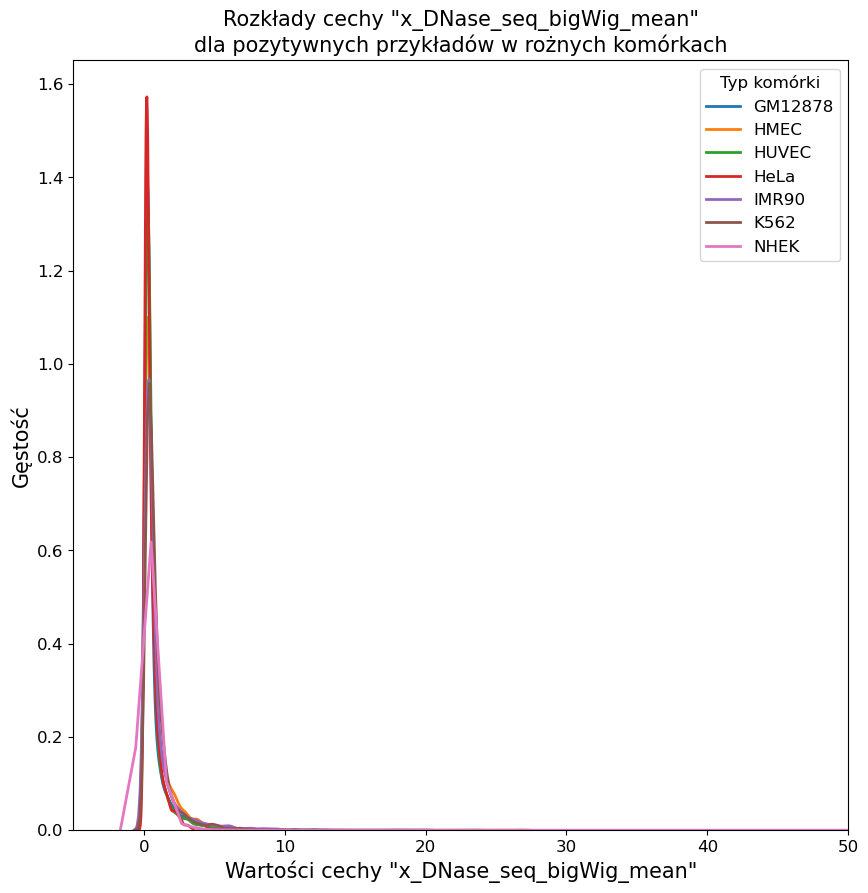

In [161]:
create_distplot(df_pos, 'mean', 'DNase_seq_bigWig', (-5, 50))

In [301]:
df_pos = df[df['label']==1]
df_pos['x_DNase_seq_bigWig_weighted_mean_log'] = np.log10(df_pos['x_DNase_seq_bigWig_weighted_mean'])
df_pos['y_DNase_seq_bigWig_weighted_mean_log'] = np.log10(df_pos['y_DNase_seq_bigWig_weighted_mean'])
df_pos['x_DNase_seq_bigWig_mean_log'] = np.log10(df_pos['x_DNase_seq_bigWig_mean'])
df_pos['y_DNase_seq_bigWig_mean_log'] = np.log10(df_pos['y_DNase_seq_bigWig_mean'])

df_pos['x_CTCF_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(df_pos['x_CTCF_ChIP_seq_bigWig_weighted_mean']+1)
df_pos['y_CTCF_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(df_pos['y_CTCF_ChIP_seq_bigWig_weighted_mean']+1)
df_pos['x_CTCF_ChIP_seq_bigWig_mean_log'] = np.log10(df_pos['x_CTCF_ChIP_seq_bigWig_mean']+1)
df_pos['y_CTCF_ChIP_seq_bigWig_mean_log'] = np.log10(df_pos['y_CTCF_ChIP_seq_bigWig_mean']+1)

df_pos['x_CTCF_ChIP_seq_peaks_distance_log'] = np.log10(df_pos['x_CTCF_ChIP_seq_peaks_distance']+1)
df_pos['y_CTCF_ChIP_seq_peaks_distance_log'] = np.log10(df_pos['y_CTCF_ChIP_seq_peaks_distance']+1)

df_pos['x_DNase_seq_peaks_distance_log'] = np.log10(df_pos['x_DNase_seq_peaks_distance']+1)
df_pos['y_DNase_seq_peaks_distance_log'] = np.log10(df_pos['y_DNase_seq_peaks_distance']+1)

df_pos['x_DNase_seq_bigWig_max_log'] = np.log10(df_pos['x_DNase_seq_bigWig_max'])
df_pos['x_CTCF_ChIP_seq_bigWig_max_log'] = np.log10(df_pos['x_CTCF_ChIP_seq_bigWig_max'])


In [286]:
def create_violin_plot(df, statistic: str, experiment: str, ylim: tuple = None, log=False, palette='hls', plus1=False):
    plt.figure(figsize=(10, 7))
    if log:
        log_add = '_log'
    else:
        log_add = ''
    sns.violinplot(df_pos, y=f'x_{experiment}_{statistic}{log_add}', x='cell_type', inner="box", palette=palette)
    if log:
        if plus1:
            plt.ylabel(f'log10(1 + x_{experiment}_{statistic})', fontsize=14)
        else:
            plt.ylabel(f'log10(x_{experiment}_{statistic})', fontsize=14)
    else: 
        plt.ylabel(f'x_{experiment}_{statistic}', fontsize=14)
    if ylim:
        plt.ylim(ylim)
    plt.xlabel('Typ komórki', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f'Rozkłady cechy "x_{experiment}_{statistic}"\nw pozytywnych przykładach w rożnych komórkach', fontsize=15)
    #plt.show()
    #plt.savefig(f'x_{experiment}_{statistic}_violinplot_positives.png', bbox_inches='tight', dpi=300)

    

In [302]:
create_violin_plot(df_pos, 'counts', 'DNase_seq_peaks', log=True, palette=['dodgerblue', 'greenyellow', 'yellow', 'orange', 'red', 'hotpink', 'mediumorchid'], plus1=False)

ValueError: Could not interpret input 'x_DNase_seq_peaks_counts_log'

<Figure size 1000x700 with 0 Axes>

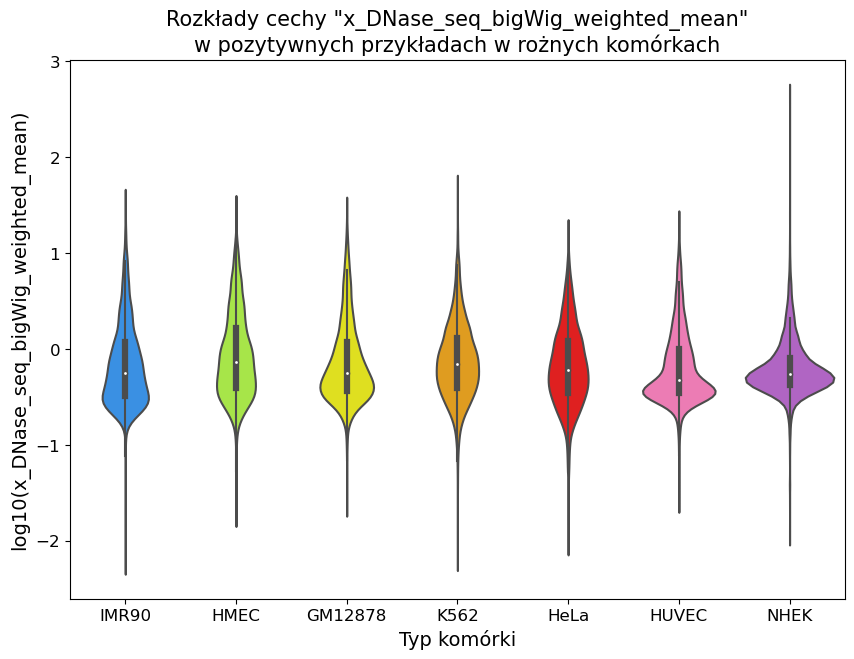

In [297]:
create_violin_plot(df_pos, 'weighted_mean', 'DNase_seq_bigWig', log=True, palette=['dodgerblue', 'greenyellow', 'yellow', 'orange', 'red', 'hotpink', 'mediumorchid'])

In [300]:
df['x_DNase_seq_bigWig_weighted_mean'].max()

453.1449279785156

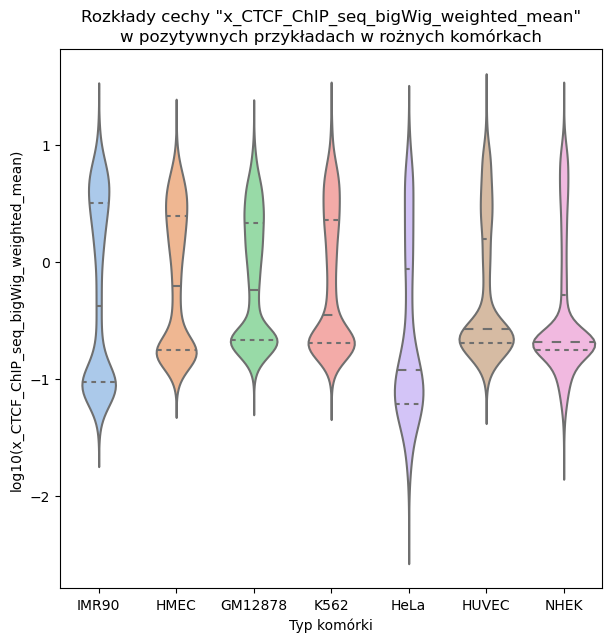

In [292]:
create_violin_plot(df_pos, 'weighted_mean', 'CTCF_ChIP_seq_bigWig', log=True)

In [44]:
df1 = pd.read_parquet('../data/04_feature/Homo_sapiens/n1/n1_concatenated_combined_functional_genomics_data.parquet', columns=['label', 'cell_type',
    'x_DNase_seq_peaks_counts', 'x_DNase_seq_peaks_distance', 'x_DNase_seq_bigWig_min', 'x_DNase_seq_bigWig_max','x_DNase_seq_bigWig_mean','x_DNase_seq_bigWig_weighted_mean',
               'x_CTCF_ChIP_seq_peaks_counts', 'x_CTCF_ChIP_seq_peaks_distance','x_CTCF_ChIP_seq_bigWig_min','x_CTCF_ChIP_seq_bigWig_max','x_CTCF_ChIP_seq_bigWig_mean','x_CTCF_ChIP_seq_bigWig_weighted_mean',
               'x_MA0139.1_f', 'x_MA0139.1_r', 'x_MA1929.1_f', 'x_MA1929.1_r','x_MA1930.1_f', 'x_MA1930.1_r', 
               'y_DNase_seq_peaks_counts', 'y_DNase_seq_peaks_distance', 'y_DNase_seq_bigWig_min', 'y_DNase_seq_bigWig_max','y_DNase_seq_bigWig_mean','y_DNase_seq_bigWig_weighted_mean',
               'y_CTCF_ChIP_seq_peaks_counts','y_CTCF_ChIP_seq_peaks_distance','y_CTCF_ChIP_seq_bigWig_min','y_CTCF_ChIP_seq_bigWig_max','y_CTCF_ChIP_seq_bigWig_mean','y_CTCF_ChIP_seq_bigWig_weighted_mean',
                'y_MA0139.1_f', 'y_MA0139.1_r','y_MA1929.1_f', 'y_MA1929.1_r','y_MA1930.1_f', 'y_MA1930.1_r'])
df2 = pd.read_parquet('../data/04_feature/Homo_sapiens/n2/n2_concatenated_combined_functional_genomics_data.parquet', columns=['label','cell_type',
    'x_DNase_seq_peaks_counts', 'x_DNase_seq_peaks_distance', 'x_DNase_seq_bigWig_min', 'x_DNase_seq_bigWig_max','x_DNase_seq_bigWig_mean','x_DNase_seq_bigWig_weighted_mean',
               'x_CTCF_ChIP_seq_peaks_counts', 'x_CTCF_ChIP_seq_peaks_distance','x_CTCF_ChIP_seq_bigWig_min','x_CTCF_ChIP_seq_bigWig_max','x_CTCF_ChIP_seq_bigWig_mean','x_CTCF_ChIP_seq_bigWig_weighted_mean',
               'x_MA0139.1_f', 'x_MA0139.1_r', 'x_MA1929.1_f', 'x_MA1929.1_r','x_MA1930.1_f', 'x_MA1930.1_r', 
               'y_DNase_seq_peaks_counts', 'y_DNase_seq_peaks_distance', 'y_DNase_seq_bigWig_min', 'y_DNase_seq_bigWig_max','y_DNase_seq_bigWig_mean','y_DNase_seq_bigWig_weighted_mean',
               'y_CTCF_ChIP_seq_peaks_counts','y_CTCF_ChIP_seq_peaks_distance','y_CTCF_ChIP_seq_bigWig_min','y_CTCF_ChIP_seq_bigWig_max','y_CTCF_ChIP_seq_bigWig_mean','y_CTCF_ChIP_seq_bigWig_weighted_mean',
                'y_MA0139.1_f', 'y_MA0139.1_r','y_MA1929.1_f', 'y_MA1929.1_r','y_MA1930.1_f', 'y_MA1930.1_r'])
df3 = pd.read_parquet('../data/04_feature/Homo_sapiens/n3/n3_concatenated_combined_functional_genomics_data.parquet', columns=['label','cell_type',
    'x_DNase_seq_peaks_counts', 'x_DNase_seq_peaks_distance', 'x_DNase_seq_bigWig_min', 'x_DNase_seq_bigWig_max','x_DNase_seq_bigWig_mean','x_DNase_seq_bigWig_weighted_mean',
               'x_CTCF_ChIP_seq_peaks_counts', 'x_CTCF_ChIP_seq_peaks_distance','x_CTCF_ChIP_seq_bigWig_min','x_CTCF_ChIP_seq_bigWig_max','x_CTCF_ChIP_seq_bigWig_mean','x_CTCF_ChIP_seq_bigWig_weighted_mean',
               'x_MA0139.1_f', 'x_MA0139.1_r', 'x_MA1929.1_f', 'x_MA1929.1_r','x_MA1930.1_f', 'x_MA1930.1_r', 
               'y_DNase_seq_peaks_counts', 'y_DNase_seq_peaks_distance', 'y_DNase_seq_bigWig_min', 'y_DNase_seq_bigWig_max','y_DNase_seq_bigWig_mean','y_DNase_seq_bigWig_weighted_mean',
               'y_CTCF_ChIP_seq_peaks_counts','y_CTCF_ChIP_seq_peaks_distance','y_CTCF_ChIP_seq_bigWig_min','y_CTCF_ChIP_seq_bigWig_max','y_CTCF_ChIP_seq_bigWig_mean','y_CTCF_ChIP_seq_bigWig_weighted_mean',
                'y_MA0139.1_f', 'y_MA0139.1_r','y_MA1929.1_f', 'y_MA1929.1_r','y_MA1930.1_f', 'y_MA1930.1_r'])

In [278]:
df1['neg_type'] = ['negatywy A' if x==0 else 'pozytywy' for x in df1['label']]
df2['neg_type'] = ['negatywy C' if x==0 else 'pozytywy' for x in df2['label']]
df3['neg_type'] = ['negatywy B' if x==0 else 'pozytywy' for x in df3['label']]

df_neg = pd.concat([df1, df2, df3])
df_neg = df_neg[df_neg['neg_type']!='pozytywy']

df = pd.concat([df_neg, df1[df1['label']==1]])
df

,label,cell_type,x_DNase_seq_peaks_counts,x_DNase_seq_peaks_distance,x_DNase_seq_bigWig_min,x_DNase_seq_bigWig_max,x_DNase_seq_bigWig_mean,x_DNase_seq_bigWig_weighted_mean,x_CTCF_ChIP_seq_peaks_counts,x_CTCF_ChIP_seq_peaks_distance,...,y_CTCF_ChIP_seq_bigWig_max,y_CTCF_ChIP_seq_bigWig_mean,y_CTCF_ChIP_seq_bigWig_weighted_mean,y_MA0139.1_f,y_MA0139.1_r,y_MA1929.1_f,y_MA1929.1_r,y_MA1930.1_f,y_MA1930.1_r,neg_type
0,0,GM12878,0,4816,0.0,1.359141,0.304675,0.203584,0,3115,...,10.841318,0.529409,0.276604,0,0,0,0,0,0,negatywy A
1,0,GM12878,0,4816,0.0,1.359141,0.304675,0.203584,0,3115,...,8.216846,0.426649,0.551979,0,0,0,0,0,0,negatywy A
2,0,GM12878,0,4816,0.0,1.359141,0.304675,0.203584,0,3115,...,0.370501,0.158098,0.157414,0,0,0,0,0,0,negatywy A
3,0,GM12878,0,4816,0.0,1.359141,0.304675,0.203584,0,3115,...,3.575671,0.348378,0.454936,0,0,0,0,0,0,negatywy A
4,0,GM12878,0,4816,0.0,1.359141,0.304675,0.203584,0,3115,...,9.780010,0.625383,0.664327,0,0,0,0,0,0,negatywy A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243509,1,NHEK,0,21261,0.0,1.712781,0.394119,0.385596,0,21715,...,0.149340,0.149340,0.149340,0,0,0,0,0,0,pozytywy
56686,1,GM12878,0,4215,0.0,0.679572,0.207496,0.183095,0,4112,...,28.875410,1.164920,0.246895,0,0,0,0,0,0,pozytywy
106163,1,HMEC,0,4255,0.0,1.176927,0.179678,0.193967,0,4242,...,26.965897,0.946936,1.652775,0,0,0,0,0,0,pozytywy
56687,1,GM12878,1,1715,0.0,19.424408,1.524506,0.965408,1,1612,...,51.572361,2.285348,1.543064,1,0,0,0,2,0,pozytywy


In [279]:
df['x_DNase_seq_bigWig_weighted_mean_log'] = np.log10(df['x_DNase_seq_bigWig_weighted_mean']+1)
df['y_DNase_seq_bigWig_weighted_mean_log'] = np.log10(df['y_DNase_seq_bigWig_weighted_mean']+1)
df['x_DNase_seq_bigWig_mean_log'] = np.log10(df['x_DNase_seq_bigWig_mean']+1)
df['y_DNase_seq_bigWig_mean_log'] = np.log10(df['y_DNase_seq_bigWig_mean']+1)

df['x_CTCF_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(df['x_CTCF_ChIP_seq_bigWig_weighted_mean']+1)
df['y_CTCF_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(df['y_CTCF_ChIP_seq_bigWig_weighted_mean']+1)
df['x_CTCF_ChIP_seq_bigWig_mean_log'] = np.log10(df['x_CTCF_ChIP_seq_bigWig_mean']+1)
df['y_CTCF_ChIP_seq_bigWig_mean_log'] = np.log10(df['y_CTCF_ChIP_seq_bigWig_mean']+1)

df['x_CTCF_ChIP_seq_peaks_distance_log'] = np.log10(df['x_CTCF_ChIP_seq_peaks_distance']+1)
df['y_CTCF_ChIP_seq_peaks_distance_log'] = np.log10(df['y_CTCF_ChIP_seq_peaks_distance']+1)

df['x_DNase_seq_peaks_distance_log'] = np.log10(df['x_DNase_seq_peaks_distance']+1)
df['y_DNase_seq_peaks_distance_log'] = np.log10(df['y_DNase_seq_peaks_distance']+1)

df['x_DNase_seq_bigWig_max_log'] = np.log10(df['x_DNase_seq_bigWig_max']+1)
df['x_CTCF_ChIP_seq_bigWig_max_log'] = np.log10(df['x_CTCF_ChIP_seq_bigWig_max']+1)


In [280]:
def create_violin_plot_negs(df, statistic: str, experiment: str, ylim: tuple = None, log=False, palette='hls', plus1=False):
    plt.figure(figsize=(10, 7))
    if log:
        log_add = '_log'
    else:
        log_add = ''
    sns.violinplot(df, y=f'x_{experiment}_{statistic}{log_add}', x='neg_type', inner="box", palette=palette, order=['pozytywy', 'negatywy A', 'negatywy B', 'negatywy C'])
    if log:
        if plus1:
            plt.ylabel(f'log10(1 + x_{experiment}_{statistic})', fontsize=14)
        else:
            plt.ylabel(f'log10(x_{experiment}_{statistic})', fontsize=14)
    else: 
        plt.ylabel(f'x_{experiment}_{statistic}', fontsize=14)
    if ylim:
        plt.ylim(ylim)
    plt.xlabel('Grupa przykładów', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f'Rozkłady cechy "x_{experiment}_{statistic}"\nw przykładach pozytywnych oraz negatywnych generowanych różnymi metodami', fontsize=15)
    #plt.show()
    #plt.savefig(f'x_{experiment}_{statistic}_violinplot_negatives.png', bbox_inches='tight', dpi=300)

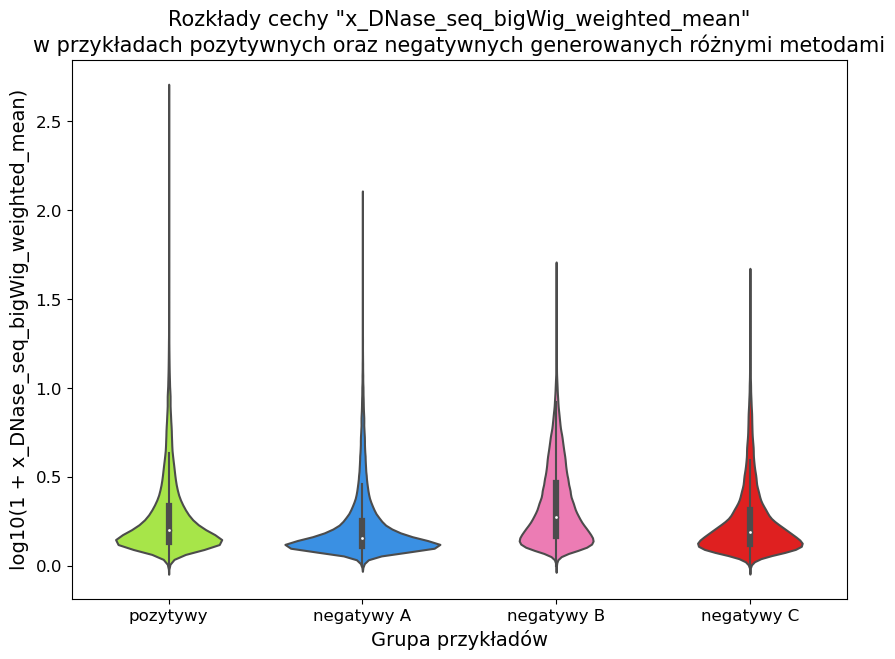

In [283]:
create_violin_plot_negs(df, 'weighted_mean', 'DNase_seq_bigWig', log=True, palette=['greenyellow', 'dodgerblue', 'hotpink', 'red'], plus1=True)

In [320]:
fly1 = pd.read_parquet('../data/04_feature/D_melanogaster/n2/n2_concatenated_combined_functional_genomics_data.parquet')
fly2 = pd.read_parquet('../data/04_feature/D_melanogaster/n3/n3_concatenated_combined_functional_genomics_data.parquet')
fly3 = pd.read_parquet('../data/04_feature/D_melanogaster/n4/n4_concatenated_combined_functional_genomics_data.parquet')

fly1['neg_type'] = ['negatywy C' if x==0 else 'pozytywy C' for x in fly1['label']]
fly2['neg_type'] = ['negatywy B' if x==0 else 'pozytywy B' for x in fly2['label']]
fly3['neg_type'] = ['negatywy D' if x==0 else 'pozytywy D' for x in fly3['label']]

fly_neg = pd.concat([fly1, fly2, fly3])
fly_neg = fly_neg[fly_neg['neg_type'].isin(['negatywy B', 'negatywy C', 'negatywy D'])]

fly_pos = pd.concat([fly1, fly2, fly3])
fly_pos = fly_pos[fly_pos['neg_type'].isin(['pozytywy B', 'pozytywy D'])]

fly_pos['neg_type'] = ['pozytywy B & C' if x=='pozytywy B' else x for x in fly_pos['neg_type']]
fly = pd.concat([fly_neg, fly_pos])
fly

,chr,x,y,x_start,x_end,y_start,y_end,cell_type,label,distance,...,y_MA1839.1_r,y_MA1839.1_f,y_MA1840.1_r,y_MA1840.1_f,y_MA1841.1_r,y_MA1841.1_f,y_MA1842.1_r,y_MA1842.1_f,neg_type,MA0916.1_f
17,2L,395730,5462000,393230,398230,5459500,5464500,neuronal,0,5066270,...,0,0,0,0,0,0,0,0,negatywy C,NaN
20,2L,395730,16422500,393230,398230,16420000,16425000,neuronal,0,16026770,...,0,0,0,0,0,0,0,0,negatywy C,NaN
28,2L,395730,21829000,393230,398230,21826500,21831500,neuronal,0,21433270,...,0,0,0,0,0,0,0,0,negatywy C,NaN
32,2L,395730,15964000,393230,398230,15961500,15966500,neuronal,0,15568270,...,0,0,1,0,0,0,0,0,negatywy C,NaN
39,2L,395730,6357019,393230,398230,6354519,6359519,neuronal,0,5961289,...,0,0,2,1,1,0,1,1,negatywy C,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,X,986370,16063376,986220,986520,16063226,16063526,neuronal,1,15077006,...,0,0,0,0,0,0,0,0,pozytywy D,0.0
120,X,1009971,16063376,1009821,1010121,16063226,16063526,neuronal,1,15053405,...,0,0,0,0,0,0,0,0,pozytywy D,0.0
124,X,1010000,17533000,1009850,1010150,17532850,17533150,neuronal,1,16523000,...,0,0,0,0,0,0,0,0,pozytywy D,0.0
127,X,5433301,17611656,5433151,5433451,17611506,17611806,neuronal,1,12178355,...,0,0,0,0,0,0,0,0,pozytywy D,0.0


In [315]:
len(fly3[fly3['label']==0])

212

In [321]:
fly['distance_log'] = np.log10(fly['distance']+1)

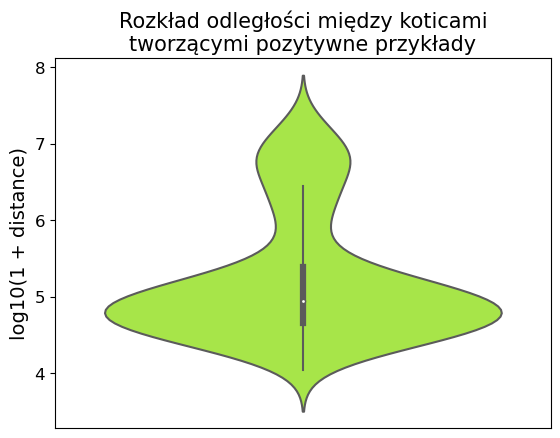

In [129]:
sns.violinplot(fly[fly['label']==1]['distance_log'], palette=['greenyellow'])

plt.ylabel(f'log10(1 + distance)', fontsize=14)
#plt.xlabel(f'log10(1 + distance)', fontsize=14)
plt.title(f'Rozkład odległości między koticami\ntworzącymi pozytywne przykłady', fontsize=15)
plt.xticks(fontsize=0)
plt.yticks(fontsize=12)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.savefig(f'fly_anchors_distance_violinplot.png', bbox_inches='tight', dpi=300)

In [332]:
def create_violin_plot_fly(df, statistic: str, experiment: str, ylim: tuple = None, log=False, palette='hls', plus1=False):
    plt.figure(figsize=(10, 7))
    if log:
        log_add = '_log'
    else:
        log_add = ''
    sns.violinplot(df, y=f'x_{experiment}_{statistic}{log_add}', x='neg_type', inner="box", palette=palette, order=['pozytywy B & C', 'negatywy B', 'negatywy C', 'pozytywy D', 'negatywy D'])
    if log:
        if plus1:
            plt.ylabel(f'log10(1 + x_{experiment}_{statistic})', fontsize=14)
        else:
            plt.ylabel(f'log10(x_{experiment}_{statistic})', fontsize=14)
    else: 
        plt.ylabel(f'x_{experiment}_{statistic}', fontsize=14)
    if ylim:
        plt.ylim(ylim)
    plt.xlabel('Grupa przykładów', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f'Rozkłady cechy "x_{experiment}_{statistic}"\nw przykładach pozytywnych oraz negatywnych generowanych różnymi metodami', fontsize=15)
    #plt.show()
    plt.savefig(f'fly_x_{experiment}_{statistic}_violinplot.png', bbox_inches='tight', dpi=300)

In [326]:
fly['x_Pita_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(fly['x_Pita_ChIP_seq_bigWig_weighted_mean']+1)
fly['x_CTCF_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(fly['x_CTCF_ChIP_seq_bigWig_weighted_mean']+1)
fly['x_CNS_L3_ATAC_seq_bigWig_weighted_mean_log'] = np.log10(fly['x_CNS_L3_ATAC_seq_bigWig_weighted_mean']+1)
fly['x_CNS_L3_ATAC_seq_bigWig_max_log'] = np.log10(fly['x_CNS_L3_ATAC_seq_bigWig_max']+1)
fly['x_CNS_L3_ATAC_seq_peaks_distance_log'] = np.log10(fly['x_CNS_L3_ATAC_seq_peaks_distance']+1)
fly['x_Ibf2_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(fly['x_Ibf2_ChIP_seq_bigWig_weighted_mean']+1)
fly['x_CP190_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(fly['x_CP190_ChIP_seq_bigWig_weighted_mean']+1)
fly['x_Zw5_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(fly['x_Zw5_ChIP_seq_bigWig_weighted_mean']+1)
fly['x_SuHw_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(fly['x_SuHw_ChIP_seq_bigWig_weighted_mean']+1)
fly['x_Beaf-32_ChIP_seq_bigWig_weighted_mean_log'] = np.log10(fly['x_Beaf-32_ChIP_seq_bigWig_weighted_mean']+1)


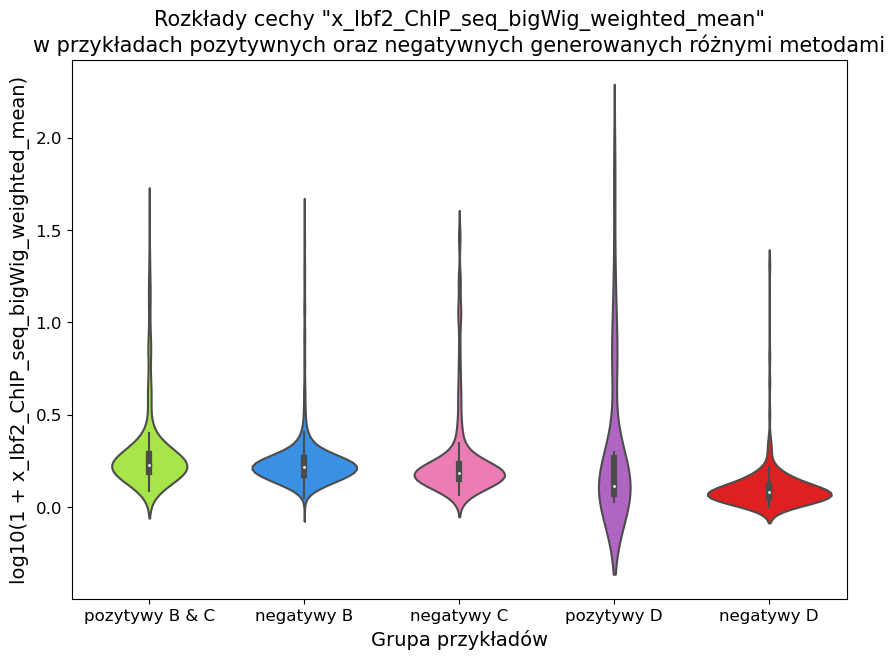

In [342]:
create_violin_plot_fly(fly, 'weighted_mean', 'Ibf2_ChIP_seq_bigWig', log=True, palette=['greenyellow', 'dodgerblue', 'hotpink', 'mediumorchid', 'red'], plus1=True)

In [310]:
fly['x_Beaf-32_ChIP_seq_bigWig_weighted_mean'].min()

0.0

In [153]:
fly['x_Chromator_ChIP_seq_bigWig_max']

17     -11.334353
20     -11.334353
28     -11.334353
32     -11.334353
39     -11.334353
          ...    
1457   -16.013674
1434    -8.180144
1511   -23.777880
1382   -10.135061
1361   -17.216433
Name: x_Chromator_ChIP_seq_bigWig_max, Length: 3133, dtype: float32

In [261]:

fly_pos = fly1[fly1['label']==1]
c2use = list(fly_pos.columns[10:126])
c2use = [x for x in c2use if ('weighted_mean' in x or 'peaks' in x) and 'x_' in x]
c2use

['x_CNS_L3_ATAC_seq_peaks_counts',
 'x_CNS_L3_ATAC_seq_peaks_distance',
 'x_CNS_L3_ATAC_seq_bigWig_weighted_mean',
 'x_Beaf-32_ChIP_seq_bigWig_weighted_mean',
 'x_Cap-H2_ChIP_seq_bigWig_weighted_mean',
 'x_Chromator_ChIP_seq_bigWig_weighted_mean',
 'x_CP190_ChIP_seq_bigWig_weighted_mean',
 'x_CTCF_ChIP_seq_bigWig_weighted_mean',
 'x_GAF_ChIP_seq_bigWig_weighted_mean',
 'x_Ibf2_ChIP_seq_bigWig_weighted_mean',
 'x_M1BP_ChIP_seq_bigWig_weighted_mean',
 'x_Pita_ChIP_seq_bigWig_weighted_mean',
 'x_Rad21_ChIP_seq_bigWig_weighted_mean',
 'x_SuHw_ChIP_seq_bigWig_weighted_mean',
 'x_ZIPIC_ChIP_seq_bigWig_weighted_mean',
 'x_Zw5_ChIP_seq_bigWig_weighted_mean']

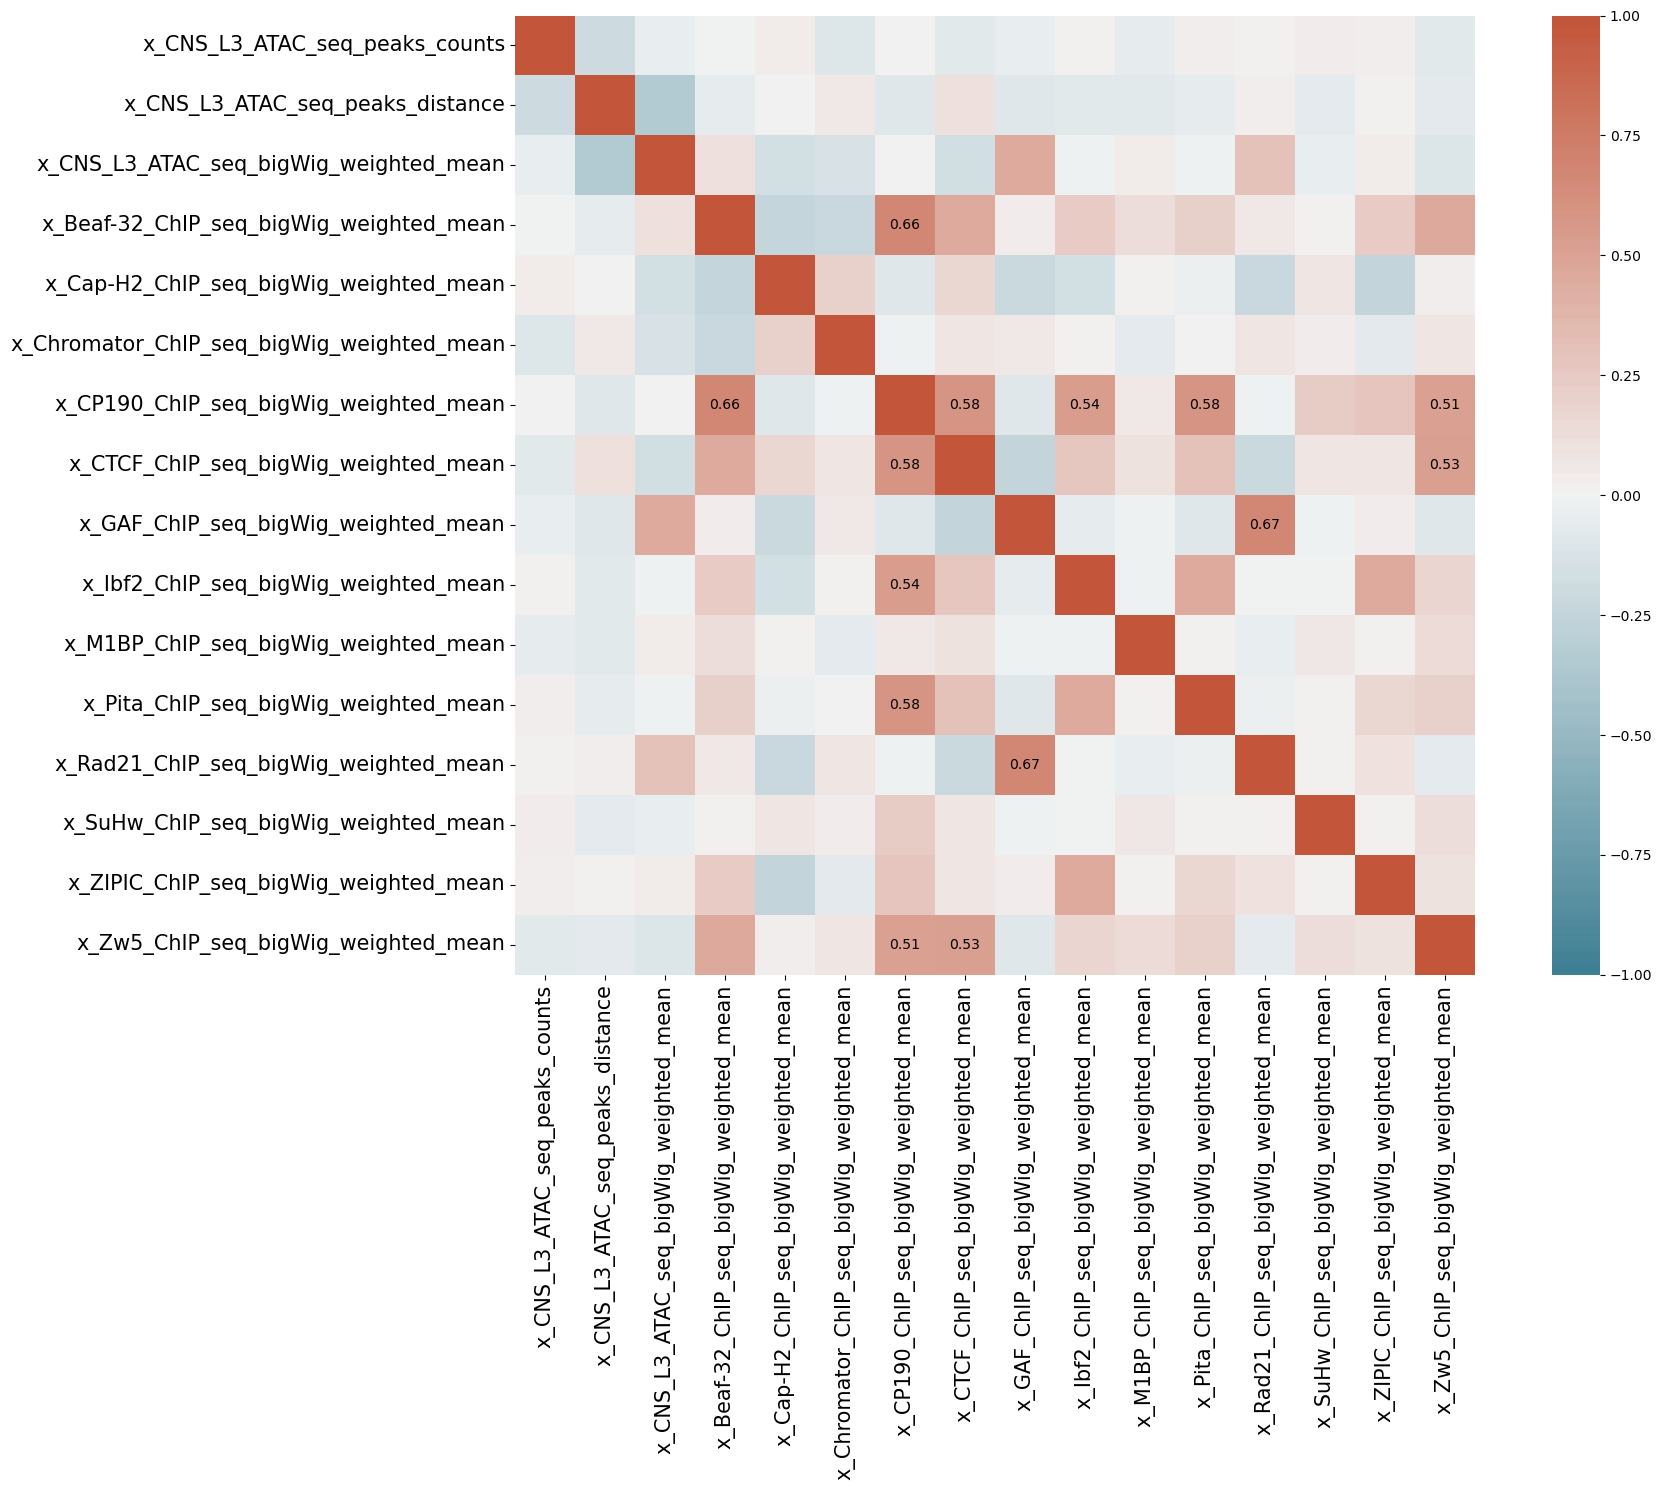

In [270]:
fig, axs = plt.subplots(figsize=(20, 15))

corr_fly = fly_pos[c2use].corr()

def func(x, thres):
    if (round(x,2) > thres or round(x,2) < -thres) and x != 1:
        return str(round(x,2))
    else:
        return ""

corr_annot_fly = corr_fly.applymap(lambda x: func(x, 0.5))

sns.heatmap(corr_fly, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    annot=corr_annot_fly,
    fmt = '',
    annot_kws={"fontsize":10, "color":'black'},
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

fig.tight_layout()
fig.savefig('FLY_positives_feature_correlation_heatmap.png', bbox_inches='tight', dpi=300)